In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from collections.abc import Iterable
import re
from typing import TextIO


data_path = "data/probe_station/7752"
path = Path(data_path, "3", "1.data")

In [2]:
def is_float(string: str):
    """Returns True if string is convertible to float, False otherwise"""
    try:
        float(string)
        return True
    except (ValueError, TypeError):  # str and None
        return False

In [3]:
def yield_pairs(lst: Iterable):
    """Yield pairs of elems from iterable and subscriptable object"""
    for pair in zip(lst[::2], lst[1::2]):
        yield pair


def non_numeric_row(df: pd.DataFrame):
    return np.argmin(df.map(is_float).all(axis=1))


def parse_metadata(file: TextIO):
    lines = [line for line in file if not line.isspace()]  # drop empty lines
    metadata = {}
    for header_str, value_str in yield_pairs(lines):
        headers_pattern = r"\s*([A-Z][a-z]+(?: [a-zA-Z]+)*)"
        headers = re.findall(headers_pattern, header_str)

        values_pattern = r"-?(?:\d+\.\d+|\de-\d\d|\d+|[A-Z]+ ?[A-Z]+)"
        values = re.findall(values_pattern, value_str)

        metadata.update(
            {
                key: float(value) if is_float(value) else value
                for key, value in zip(headers, values)
            }
        )
        file.seek(0)  # return cursor to the beginning

    return metadata


def parse_datafile(path: Path):
    with open(path, "r") as file:
        metadata = parse_metadata(file)
        lines = file.readlines()
    data = [
        line.strip().split() for line in lines[len(metadata.keys()) + 2 :]
    ]  # TODO: change to len + 1 + PQPUND for versatility, check other modes
    df = pd.DataFrame(data[1:]).iloc[:, :3].dropna(how="all")
    df.columns = data[0]
    dfs = []
    while True:
        row = non_numeric_row(df)
        if row == 0:
            dfs.append(df.map(float).reset_index(drop=True))
            break
        numeric_df = df.iloc[:row].map(float).reset_index(drop=True)
        dfs.append(numeric_df)
        df = df.iloc[row + 2 :].dropna(axis=1, how="all")

    row = non_numeric_row(df)
    return metadata, *dfs


metadata, current, leak, qv = parse_datafile(path)
current["DiffCurrent"] = current["CurrentP"] - current["CurrentC"] + leak["CurrentP"]
# current["DiffCurrent"] = current["CurrentP"] - current["CurrentC"]

In [4]:
steps = metadata["Steps"]
wait_time, rump_time = metadata["Wait Time"], metadata["Rump time"]
k1 = metadata["First Bias"] / steps / (wait_time + rump_time)
k2 = metadata["Second Bias"] / steps / (wait_time + rump_time)
k1, k2
# current["Time"] = current['Voltages'] / k1 if current['Voltages'] < 0 else current['Voltages'] / k2

# current["Time"] = np.abs(current['Voltages'] / k1)
voltage_step = (metadata["Second Bias"] - metadata["First Bias"]) / (
    (steps)
)  # incorrect
voltage_step
# current['Voltages'][300]-current['Voltages'][299]
time_step = -voltage_step / k1
time = [i * time_step for i in range(len(current["Voltages"]))]
# plt.plot(time, current['CurrentC'])
# plt.xlim(0, 0.02)
charge = scipy.integrate.simpson(y=current["DiffCurrent"], x=time)
charge / ((25e-6) ** 2)

11.537705597851366

In [5]:
# current.plot("Voltages", y=["CurrentP", "CurrentC", "DiffCurrent"])
# leak.plot("Voltages", y=["CurrentP", "CurrentC", "DiffCurrent"])

24.968678604000004
25.17866225946667
25.263347632000002
25.321827226666667
25.406603813333334


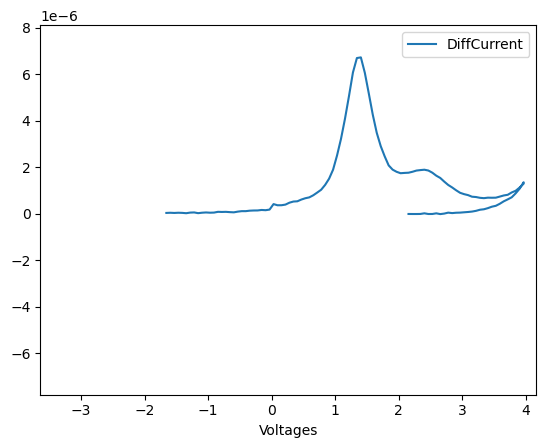

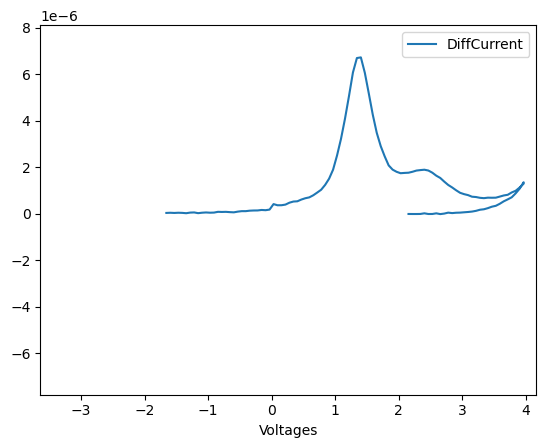

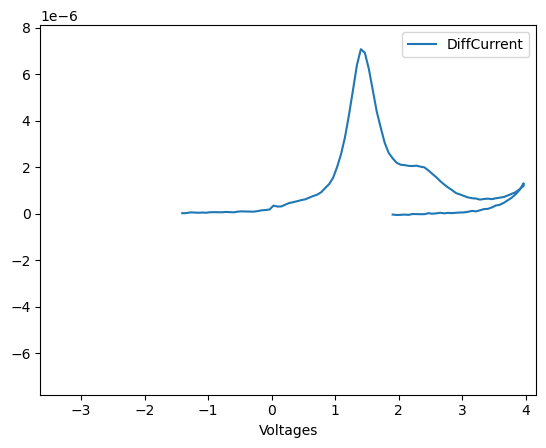

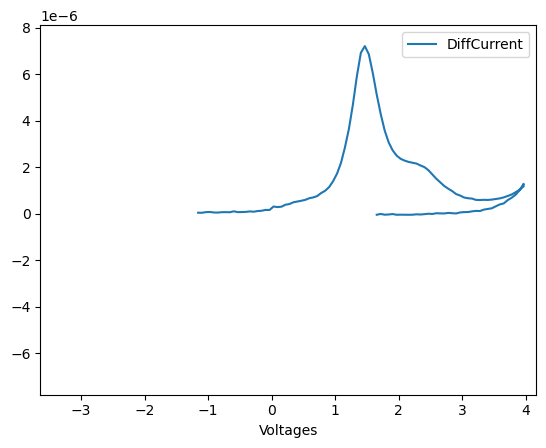

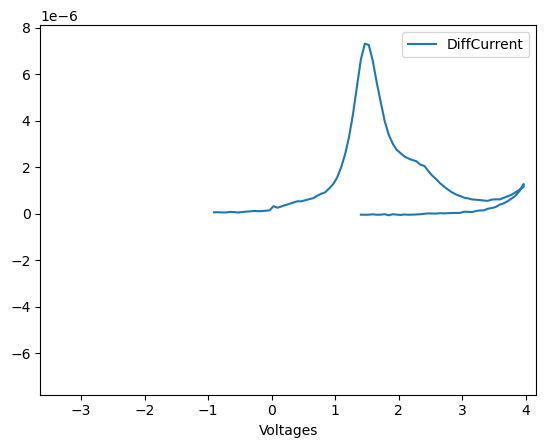

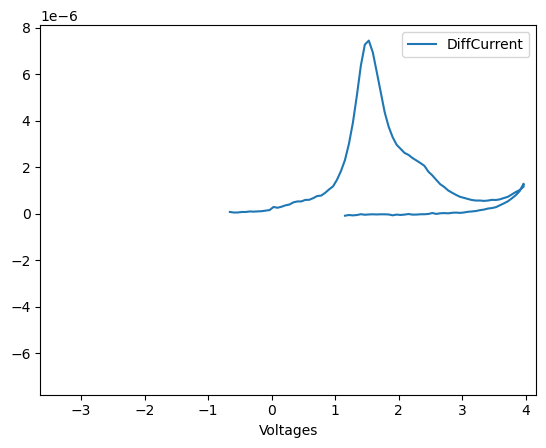

In [6]:
def get_one_cycle(df: pd.DataFrame, metadata: dict, cycle: int):
    steps_per_cycle = 2 * int(metadata["Steps"])
    df = df[cycle * steps_per_cycle : (cycle + 1) * steps_per_cycle]
    df.plot("Voltages", y=["DiffCurrent"])
    return df


def get_half_cycle(df: pd.DataFrame, metadata: dict, cycle: int, shift: int = -40):
    steps_per_cycle = 2 * int(metadata["Steps"])
    df1 = df[
        int((cycle + 1.5) * steps_per_cycle)
        + shift : (2 + cycle) * steps_per_cycle
        + shift
    ]
    df1.plot(
        "Voltages",
        y=["DiffCurrent"],
        xlim=(df["Voltages"].min() * 1.05, df["Voltages"].max() * 1.05),
        ylim=(df["DiffCurrent"].min() * 1.05, df["DiffCurrent"].max() * 1.05),
    )
    return df1


def plot_point_on_data(df: pd.DataFrame, point: int, column: str = "DiffCurrent"):
    plt.plot(df["Voltages"].iloc[point], df[column].iloc[point], "o")


df_cycle = get_half_cycle(current, metadata, 1)

time_step = rump_time + wait_time


cycle = 121
point = cycle + 0
# plot_point_on_data(df_cycle, cycle - 10)
# plot_point_on_data(df_cycle, cycle + 21)
# plot_point_on_data(df_cycle, cycle + 50)


def integrate(df, a, b):
    return scipy.integrate.simpson(y=df["DiffCurrent"][a:b], x=df_cycle["Time"][a:b])


for i in range(1, 10, 2):
    df_cycle = get_half_cycle(current, metadata, i)
    times = np.array([time_step * i for i in range(df_cycle["Voltages"].size)])
    charge = scipy.integrate.simpson(y=df_cycle["DiffCurrent"], x=times)
    polarization = charge / (100e-4) ** 2 * 1e6

    print(polarization)
# polarization, integrate(df_cycle, cycle - 10, cycle + 21), integrate(
#     df_cycle, cycle + 21, cycle + 50
# )

In [7]:
# интеграл первый(CurrentP) - первый(CurrentC) + Leakage(CurrentP) ИНТЕГРАЛ по времени!

In [8]:
first["DiffCurrent"] = first["CurrentP"] - first["CurrentC"]
to_plot = first.iloc[100:180]
# cycle = 350


to_plot.plot(
    x="Voltages",
    y="DiffCurrent",
    xlim=(first["Voltages"].min() * 1.05, first["Voltages"].max() * 1.05),
    ylim=(first["DiffCurrent"].min() * 1.05, first["DiffCurrent"].max() * 1.05),
)

from scipy.signal import argrelextrema

minimums = argrelextrema(to_plot["DiffCurrent"].values, np.less)[0]
minimums = minimums[5:8]
print(to_plot["DiffCurrent"].iloc[minimums])
print(minimums)
plt.plot(to_plot["Voltages"].iloc[minimums], to_plot["DiffCurrent"].iloc[minimums], "o")

NameError: name 'first' is not defined

In [ ]:
def get_pfm_pulse(real_voltage: float):
    v_pfm = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, -0.5, -1.0, -1.5, -2.0, -2.5, -3.0, -3.5, -4.0, -4.5]  # fmt: skip
    v_real = [0.36, 0.75, 1.12, 1.48, 1.88, 2.2, 2.58, 2.92, 3.32, -0.366, -0.72, -1.1, -1.47, -1.82, -2.19, -2.56, -2.93, -3.3]  # fmt: skip
    k, b = np.polyfit(v_pfm, v_real, 1)
    return (real_voltage - b) / k


get_pfm_pulse(3.5)